BTC

In [1]:
# Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Mounted at /content/drive


In [2]:
# Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/DataBA/BTC.csv')
df1=df.reset_index()['Close']


In [3]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]


In [5]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)


In [6]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
21/21 [==============================] - 18s 272ms/step - loss: 0.0296
Epoch 2/100
21/21 [==============================] - 6s 286ms/step - loss: 0.0045
Epoch 3/100
21/21 [==============================] - 5s 256ms/step - loss: 0.0025
Epoch 4/100
21/21 [==============================] - 4s 200ms/step - loss: 0.0024
Epoch 5/100
21/21 [==============================] - 4s 212ms/step - loss: 0.0022
Epoch 6/100
21/21 [==============================] - 6s 301ms/step - loss: 0.0020
Epoch 7/100
21/21 [==============================] - 4s 170ms/step - loss: 0.0019
Epoch 8/100
21/21 [==============================] - 3s 160ms/step - loss: 0.0018
Epoch 9/100
21/21 [==============================] - 4s 199ms/step - loss: 0.0016
Epoch 10/100
21/21 [==============================] - 5s 220ms/step - loss: 0.0017
Epoch 11/100
21/21 [==============================] - 3s 161ms/step - loss: 0.0016
Epoch 12/100
21/21 [==============================] - 3s 162ms/step - loss: 0.0016
Epoch 13/100

In [10]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

16/16 [==============================] - 1s 61ms/step


In [11]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [12]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
import math
from sklearn.metrics import mean_squared_error

# Hàm tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm tính MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính MASE
def mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính sai số tuyệt đối trung bình của mô hình
    mae = np.mean(np.abs(y_true - y_pred))

    # Tính sai số tuyệt đối trung bình của phương pháp đơn giản (naive forecast)
    naive_forecast_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))

    if naive_forecast_error == 0:
        return np.inf
    else:
        return mae / naive_forecast_error

rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)
mase_value = mase(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_value)
print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Scaled Error (MASE):", mase_value)

Root Mean Squared Error (RMSE): 41871.191234926264
Mean Absolute Percentage Error (MAPE): 8818614.998928009
Mean Absolute Scaled Error (MASE): 3767415.874772014


In [13]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.88460666]
101
1 day input [0.94063252 0.98574693 0.97684399 1.         0.97624905 0.94898831
 0.88807934 0.93633355 0.92286924 0.84065993 0.92491314 0.89080009
 0.86341985 0.87303752 0.91620228 0.95429367 0.95656008 0.94895488
 0.96578137 0.95355527 0.95103407 0.97315874 0.95184435 0.89040098
 0.89937896 0.93362428 0.92598551 0.93998867 0.94693049 0.97910939
 0.94419726 0.96306793 0.95730722 0.91564823 0.87329446 0.89233197
 0.86240528 0.86502877 0.83103107 0.86127323 0.86913421 0.88193157
 0.88248935 0.91006298 0.90386142 0.87379844 0.87672793 0.86684284
 0.86220759 0.85612654 0.86701127 0.82316908 0.78736232 0.7998214
 0.85240686 0.86790173 0.87019726 0.85810545 0.84638807 0.82974106
 0.85685475 0.82497669 0.82348885 0.834474   0.85408838 0.83522373
 0.90186745 0.88755499 0.91271918 0.91143577 0.90329388 0.97604505
 0.95719748 0.94458131 0.92591665 0.93468188 0.94515516 0.93493509
 0.94775511 0.93270913 0.92220903 0.93240126 0.92092763 0.92339144
 0.92387232 0.93860914 0.96429309 

In [14]:
# Dự báo 60 ngày tiếp theo

x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.88460666]
101
1 day input [0.94063252 0.98574693 0.97684399 1.         0.97624905 0.94898831
 0.88807934 0.93633355 0.92286924 0.84065993 0.92491314 0.89080009
 0.86341985 0.87303752 0.91620228 0.95429367 0.95656008 0.94895488
 0.96578137 0.95355527 0.95103407 0.97315874 0.95184435 0.89040098
 0.89937896 0.93362428 0.92598551 0.93998867 0.94693049 0.97910939
 0.94419726 0.96306793 0.95730722 0.91564823 0.87329446 0.89233197
 0.86240528 0.86502877 0.83103107 0.86127323 0.86913421 0.88193157
 0.88248935 0.91006298 0.90386142 0.87379844 0.87672793 0.86684284
 0.86220759 0.85612654 0.86701127 0.82316908 0.78736232 0.7998214
 0.85240686 0.86790173 0.87019726 0.85810545 0.84638807 0.82974106
 0.85685475 0.82497669 0.82348885 0.834474   0.85408838 0.83522373
 0.90186745 0.88755499 0.91271918 0.91143577 0.90329388 0.97604505
 0.95719748 0.94458131 0.92591665 0.93468188 0.94515516 0.93493509
 0.94775511 0.93270913 0.92220903 0.93240126 0.92092763 0.92339144
 0.92387232 0.93860914 0.96429309 

In [15]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1



[0.88460666]
101
1 day input [0.94063252 0.98574693 0.97684399 1.         0.97624905 0.94898831
 0.88807934 0.93633355 0.92286924 0.84065993 0.92491314 0.89080009
 0.86341985 0.87303752 0.91620228 0.95429367 0.95656008 0.94895488
 0.96578137 0.95355527 0.95103407 0.97315874 0.95184435 0.89040098
 0.89937896 0.93362428 0.92598551 0.93998867 0.94693049 0.97910939
 0.94419726 0.96306793 0.95730722 0.91564823 0.87329446 0.89233197
 0.86240528 0.86502877 0.83103107 0.86127323 0.86913421 0.88193157
 0.88248935 0.91006298 0.90386142 0.87379844 0.87672793 0.86684284
 0.86220759 0.85612654 0.86701127 0.82316908 0.78736232 0.7998214
 0.85240686 0.86790173 0.87019726 0.85810545 0.84638807 0.82974106
 0.85685475 0.82497669 0.82348885 0.834474   0.85408838 0.83522373
 0.90186745 0.88755499 0.91271918 0.91143577 0.90329388 0.97604505
 0.95719748 0.94458131 0.92591665 0.93468188 0.94515516 0.93493509
 0.94775511 0.93270913 0.92220903 0.93240126 0.92092763 0.92339144
 0.92387232 0.93860914 0.96429309 

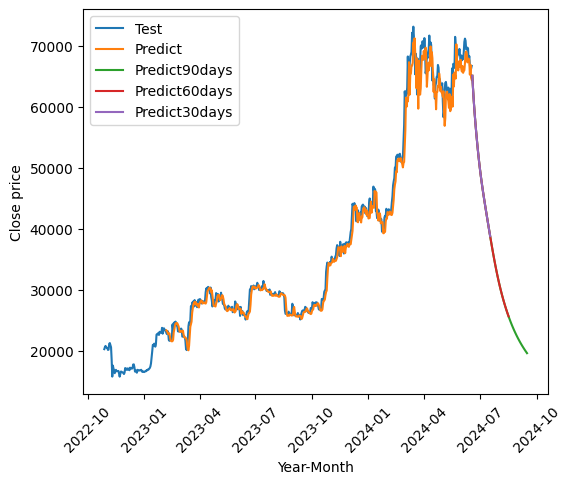

In [16]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Create the figure

# Assuming 'df' has a 'Date' column and 'train_size' is defined
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df['Date'][train_size+101:], y_pred, label='Predict')

# Generate future dates for predictions
predict_data_index_90 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=90, freq='D'
)
predict_data_index_60 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=60, freq='D'
)
predict_data_index_30 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=30, freq='D'
)

# Plot predictions (assuming lst_output_90, lst_output_60, lst_output_30 are predictions)
plt.plot(predict_data_index_90, scaler.inverse_transform(lst_output_90), label='Predict90days')
plt.plot(predict_data_index_60, scaler.inverse_transform(lst_output_60), label='Predict60days')
plt.plot(predict_data_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Year-Month')
plt.ylabel('Close price')
plt.legend()  # Use legend() to automatically generate labels from label arguments in plot

plt.show()


ETH

In [17]:
# Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/DataBA/ETH.csv')
df1=df.reset_index()['Close']


In [19]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [20]:
# Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [21]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [22]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [23]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
21/21 [==============================] - 10s 158ms/step - loss: 0.0110
Epoch 2/100
21/21 [==============================] - 4s 175ms/step - loss: 0.0031
Epoch 3/100
21/21 [==============================] - 6s 308ms/step - loss: 0.0024
Epoch 4/100
21/21 [==============================] - 5s 213ms/step - loss: 0.0020
Epoch 5/100
21/21 [==============================] - 3s 157ms/step - loss: 0.0021
Epoch 6/100
21/21 [==============================] - 3s 159ms/step - loss: 0.0020
Epoch 7/100
21/21 [==============================] - 4s 213ms/step - loss: 0.0018
Epoch 8/100
21/21 [==============================] - 5s 217ms/step - loss: 0.0017
Epoch 9/100
21/21 [==============================] - 3s 160ms/step - loss: 0.0020
Epoch 10/100
21/21 [==============================] - 3s 160ms/step - loss: 0.0016
Epoch 11/100
21/21 [==============================] - 4s 213ms/step - loss: 0.0017
Epoch 12/100
21/21 [==============================] - 4s 210ms/step - loss: 0.0018
Epoch 13/100

In [26]:
# Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

16/16 [==============================] - 1s 39ms/step


In [27]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [28]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
import math
from sklearn.metrics import mean_squared_error

# Hàm tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm tính MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính MASE
def mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính sai số tuyệt đối trung bình của mô hình
    mae = np.mean(np.abs(y_true - y_pred))

    # Tính sai số tuyệt đối trung bình của phương pháp đơn giản (naive forecast)
    naive_forecast_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))

    if naive_forecast_error == 0:
        return np.inf
    else:
        return mae / naive_forecast_error

rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)
mase_value = mase(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_value)
print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Scaled Error (MASE):", mase_value)

Root Mean Squared Error (RMSE): 0.046223637233940504
Mean Absolute Percentage Error (MAPE): 39.842276026099775
Mean Absolute Scaled Error (MASE): 13.393618329411972


In [29]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1

[0.19547069]
101
1 day input [0.24657947 0.26366048 0.24440877 0.24585968 0.25795399 0.23768444
 0.20600597 0.22442713 0.20864668 0.18670536 0.22033342 0.22545982
 0.22132138 0.23522993 0.2567011  0.25446727 0.26557974 0.27636179
 0.3203745  0.31102645 0.29086279 0.32027641 0.29949815 0.26512473
 0.25559784 0.26133534 0.25852953 0.27014114 0.28972023 0.29540592
 0.2747533  0.29133327 0.28252894 0.25392045 0.22297339 0.23629846
 0.23431394 0.22650525 0.21441622 0.22003334 0.22742567 0.2364385
 0.22992733 0.23388814 0.23142442 0.22025745 0.21998503 0.21480543
 0.2148188  0.21227452 0.20829566 0.1937539  0.18910755 0.19197399
 0.21229393 0.23280293 0.23346268 0.22667026 0.21820448 0.20869125
 0.2198635  0.20846709 0.20720449 0.20443395 0.21547275 0.21091702
 0.22601421 0.2177961  0.22665195 0.22146492 0.21658517 0.24068736
 0.2476306  0.24037503 0.23179567 0.23791425 0.25065812 0.24199428
 0.24619766 0.24043619 0.23882429 0.23136084 0.23159777 0.2331809
 0.22832575 0.22880935 0.23480105 0

In [30]:
# Dự báo 60 ngày tiếp theo

x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


[0.19547069]
101
1 day input [0.24657947 0.26366048 0.24440877 0.24585968 0.25795399 0.23768444
 0.20600597 0.22442713 0.20864668 0.18670536 0.22033342 0.22545982
 0.22132138 0.23522993 0.2567011  0.25446727 0.26557974 0.27636179
 0.3203745  0.31102645 0.29086279 0.32027641 0.29949815 0.26512473
 0.25559784 0.26133534 0.25852953 0.27014114 0.28972023 0.29540592
 0.2747533  0.29133327 0.28252894 0.25392045 0.22297339 0.23629846
 0.23431394 0.22650525 0.21441622 0.22003334 0.22742567 0.2364385
 0.22992733 0.23388814 0.23142442 0.22025745 0.21998503 0.21480543
 0.2148188  0.21227452 0.20829566 0.1937539  0.18910755 0.19197399
 0.21229393 0.23280293 0.23346268 0.22667026 0.21820448 0.20869125
 0.2198635  0.20846709 0.20720449 0.20443395 0.21547275 0.21091702
 0.22601421 0.2177961  0.22665195 0.22146492 0.21658517 0.24068736
 0.2476306  0.24037503 0.23179567 0.23791425 0.25065812 0.24199428
 0.24619766 0.24043619 0.23882429 0.23136084 0.23159777 0.2331809
 0.22832575 0.22880935 0.23480105 0

In [31]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


[0.19547069]
101
1 day input [0.24657947 0.26366048 0.24440877 0.24585968 0.25795399 0.23768444
 0.20600597 0.22442713 0.20864668 0.18670536 0.22033342 0.22545982
 0.22132138 0.23522993 0.2567011  0.25446727 0.26557974 0.27636179
 0.3203745  0.31102645 0.29086279 0.32027641 0.29949815 0.26512473
 0.25559784 0.26133534 0.25852953 0.27014114 0.28972023 0.29540592
 0.2747533  0.29133327 0.28252894 0.25392045 0.22297339 0.23629846
 0.23431394 0.22650525 0.21441622 0.22003334 0.22742567 0.2364385
 0.22992733 0.23388814 0.23142442 0.22025745 0.21998503 0.21480543
 0.2148188  0.21227452 0.20829566 0.1937539  0.18910755 0.19197399
 0.21229393 0.23280293 0.23346268 0.22667026 0.21820448 0.20869125
 0.2198635  0.20846709 0.20720449 0.20443395 0.21547275 0.21091702
 0.22601421 0.2177961  0.22665195 0.22146492 0.21658517 0.24068736
 0.2476306  0.24037503 0.23179567 0.23791425 0.25065812 0.24199428
 0.24619766 0.24043619 0.23882429 0.23136084 0.23159777 0.2331809
 0.22832575 0.22880935 0.23480105 0

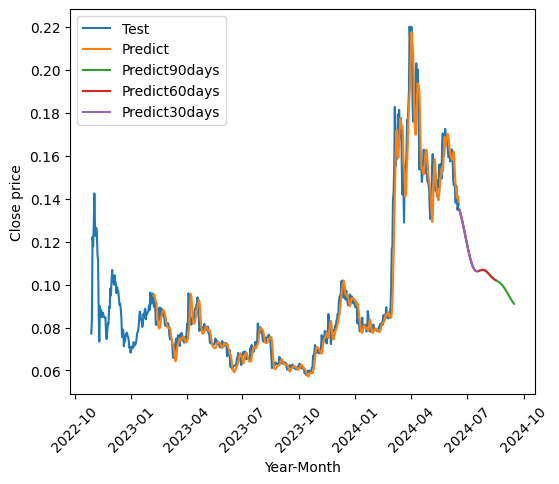

In [32]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Create the figure

# Assuming 'df' has a 'Date' column and 'train_size' is defined
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df['Date'][train_size+101:], y_pred, label='Predict')

# Generate future dates for predictions
predict_data_index_90 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=90, freq='D'
)
predict_data_index_60 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=60, freq='D'
)
predict_data_index_30 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=30, freq='D'
)

# Plot predictions (assuming lst_output_90, lst_output_60, lst_output_30 are predictions)
plt.plot(predict_data_index_90, scaler.inverse_transform(lst_output_90), label='Predict90days')
plt.plot(predict_data_index_60, scaler.inverse_transform(lst_output_60), label='Predict60days')
plt.plot(predict_data_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Year-Month')
plt.ylabel('Close price')
plt.legend()  # Use legend() to automatically generate labels from label arguments in plot

plt.show()


DOGE

In [33]:
# Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/DataBA/DOGE.csv')
df1=df.reset_index()['Close']


In [35]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [36]:
# Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

In [37]:
# Hàm  Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [38]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [39]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [40]:
# Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [41]:
# Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
21/21 [==============================] - 11s 168ms/step - loss: 0.0367
Epoch 2/100
21/21 [==============================] - 4s 173ms/step - loss: 0.0047
Epoch 3/100
21/21 [==============================] - 6s 265ms/step - loss: 0.0036
Epoch 4/100
21/21 [==============================] - 3s 161ms/step - loss: 0.0031
Epoch 5/100
21/21 [==============================] - 3s 161ms/step - loss: 0.0028
Epoch 6/100
21/21 [==============================] - 4s 172ms/step - loss: 0.0028
Epoch 7/100
21/21 [==============================] - 5s 258ms/step - loss: 0.0026
Epoch 8/100
21/21 [==============================] - 4s 168ms/step - loss: 0.0026
Epoch 9/100
21/21 [==============================] - 3s 166ms/step - loss: 0.0028
Epoch 10/100
21/21 [==============================] - 4s 199ms/step - loss: 0.0022
Epoch 11/100
21/21 [==============================] - 5s 237ms/step - loss: 0.0022
Epoch 12/100
21/21 [==============================] - 3s 163ms/step - loss: 0.0020
Epoch 13/100

In [42]:
# Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

16/16 [==============================] - 1s 37ms/step


In [43]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [44]:
# Đánh giá độ chính xác của mô hình trên tập kiểm tra
import math
from sklearn.metrics import mean_squared_error

# Hàm tính RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Hàm tính MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hàm tính MASE
def mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Tính sai số tuyệt đối trung bình của mô hình
    mae = np.mean(np.abs(y_true - y_pred))

    # Tính sai số tuyệt đối trung bình của phương pháp đơn giản (naive forecast)
    naive_forecast_error = np.mean(np.abs(y_true[1:] - y_true[:-1]))

    if naive_forecast_error == 0:
        return np.inf
    else:
        return mae / naive_forecast_error

rmse_value = rmse(y_test, y_pred)
mape_value = mape(y_test, y_pred)
mase_value = mase(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_value)
print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Scaled Error (MASE):", mase_value)

Root Mean Squared Error (RMSE): 2378.961509605141
Mean Absolute Percentage Error (MAPE): 541362.4280106617
Mean Absolute Scaled Error (MASE): 242914.72598731873


In [45]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_30=[]
n_steps=x_input.shape[1]
i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i=i+1


[0.7550824]
101
1 day input [0.80402215 0.84177966 0.82265795 0.83010058 0.80302353 0.77308188
 0.727115   0.75493004 0.72630459 0.65032214 0.72337214 0.72050724
 0.6834889  0.68977513 0.7118487  0.73968127 0.74047738 0.72227239
 0.7344512  0.72457861 0.72428995 0.75281667 0.72271125 0.67347893
 0.68231592 0.68447216 0.68334106 0.69163459 0.71218158 0.76254945
 0.72239682 0.73030996 0.72377198 0.66617039 0.61935557 0.64722799
 0.63643426 0.63226919 0.61141791 0.62837904 0.62839624 0.64737889
 0.64638217 0.657701   0.66147406 0.64460433 0.64819835 0.6431355
 0.67068902 0.67092696 0.66112837 0.61958818 0.6096219  0.61338282
 0.63732875 0.640266   0.64510949 0.62917897 0.61817675 0.61000992
 0.62298969 0.59610272 0.59670897 0.60147917 0.60398778 0.59000105
 0.62233387 0.6028485  0.63466745 0.64062465 0.63057171 0.75311907
 0.78045562 0.77121556 0.77600574 0.7688786  0.77261288 0.78447045
 0.79728933 0.78843968 0.77541949 0.77246536 0.7743046  0.78071043
 0.77695776 0.77512359 0.78304475 0

In [46]:
# Dự báo 60 ngày tiếp theo

x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_60=[]
n_steps=x_input.shape[1]
i=0
while(i<60):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1

[0.7550824]
101
1 day input [0.80402215 0.84177966 0.82265795 0.83010058 0.80302353 0.77308188
 0.727115   0.75493004 0.72630459 0.65032214 0.72337214 0.72050724
 0.6834889  0.68977513 0.7118487  0.73968127 0.74047738 0.72227239
 0.7344512  0.72457861 0.72428995 0.75281667 0.72271125 0.67347893
 0.68231592 0.68447216 0.68334106 0.69163459 0.71218158 0.76254945
 0.72239682 0.73030996 0.72377198 0.66617039 0.61935557 0.64722799
 0.63643426 0.63226919 0.61141791 0.62837904 0.62839624 0.64737889
 0.64638217 0.657701   0.66147406 0.64460433 0.64819835 0.6431355
 0.67068902 0.67092696 0.66112837 0.61958818 0.6096219  0.61338282
 0.63732875 0.640266   0.64510949 0.62917897 0.61817675 0.61000992
 0.62298969 0.59610272 0.59670897 0.60147917 0.60398778 0.59000105
 0.62233387 0.6028485  0.63466745 0.64062465 0.63057171 0.75311907
 0.78045562 0.77121556 0.77600574 0.7688786  0.77261288 0.78447045
 0.79728933 0.78843968 0.77541949 0.77246536 0.7743046  0.78071043
 0.77695776 0.77512359 0.78304475 0

In [47]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)

temp_input = list(x_input[0])

from numpy import array

lst_output_90=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1



[0.7550824]
101
1 day input [0.80402215 0.84177966 0.82265795 0.83010058 0.80302353 0.77308188
 0.727115   0.75493004 0.72630459 0.65032214 0.72337214 0.72050724
 0.6834889  0.68977513 0.7118487  0.73968127 0.74047738 0.72227239
 0.7344512  0.72457861 0.72428995 0.75281667 0.72271125 0.67347893
 0.68231592 0.68447216 0.68334106 0.69163459 0.71218158 0.76254945
 0.72239682 0.73030996 0.72377198 0.66617039 0.61935557 0.64722799
 0.63643426 0.63226919 0.61141791 0.62837904 0.62839624 0.64737889
 0.64638217 0.657701   0.66147406 0.64460433 0.64819835 0.6431355
 0.67068902 0.67092696 0.66112837 0.61958818 0.6096219  0.61338282
 0.63732875 0.640266   0.64510949 0.62917897 0.61817675 0.61000992
 0.62298969 0.59610272 0.59670897 0.60147917 0.60398778 0.59000105
 0.62233387 0.6028485  0.63466745 0.64062465 0.63057171 0.75311907
 0.78045562 0.77121556 0.77600574 0.7688786  0.77261288 0.78447045
 0.79728933 0.78843968 0.77541949 0.77246536 0.7743046  0.78071043
 0.77695776 0.77512359 0.78304475 0

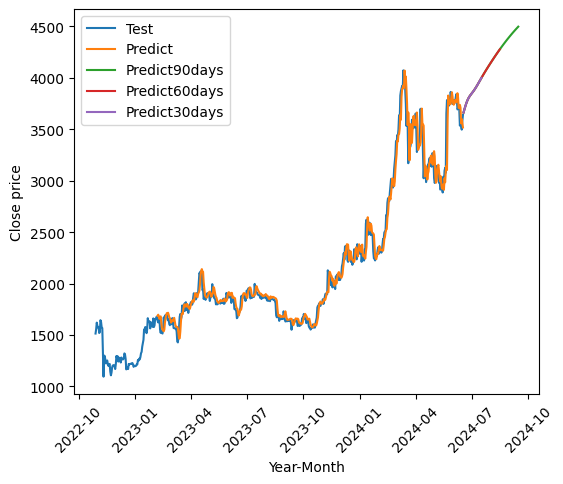

In [48]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))  # Create the figure

# Assuming 'df' has a 'Date' column and 'train_size' is defined
df['Date'] = pd.to_datetime(df['Date'])

# Plot the data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test')
plt.plot(df['Date'][train_size+101:], y_pred, label='Predict')

# Generate future dates for predictions
predict_data_index_90 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=90, freq='D'
)
predict_data_index_60 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=60, freq='D'
)
predict_data_index_30 = pd.bdate_range(
    start=df['Date'][len(df['Date']) - 1] + pd.Timedelta(days=1), periods=30, freq='D'
)

# Plot predictions (assuming lst_output_90, lst_output_60, lst_output_30 are predictions)
plt.plot(predict_data_index_90, scaler.inverse_transform(lst_output_90), label='Predict90days')
plt.plot(predict_data_index_60, scaler.inverse_transform(lst_output_60), label='Predict60days')
plt.plot(predict_data_index_30, scaler.inverse_transform(lst_output_30), label='Predict30days')

# Set x-axis formatting and rotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees

plt.xlabel('Year-Month')
plt.ylabel('Close price')
plt.legend()  # Use legend() to automatically generate labels from label arguments in plot

plt.show()
